## 1.4. 近似推論手法

### 1.4.3. モンテカルロ法

In [12]:
%matplotlib inline

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

groud truth:  0.9545
M = 100, estimation: 0.9518 ± 0.0489
M = 1000, estimation: 0.9536 ± 0.0130
M = 10000, estimation: 0.9544 ± 0.0048
M = 100000, estimation: 0.9545 ± 0.0014


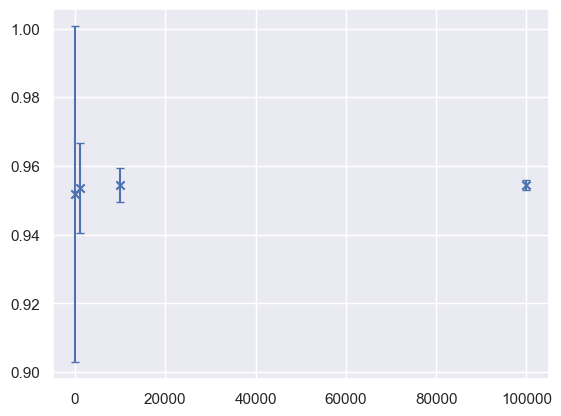

In [13]:
def montecarlo(M, trial=100, seed=1):
    rng = np.random.default_rng(seed=seed)
    x = rng.uniform(low=-2, high=2, size=(M, trial))
    res = 4 * stats.norm(0, 1).pdf(x).mean(axis=0)
    return res.mean(), res.std()

ground_truth = stats.norm(0, 1).cdf(2) - stats.norm(0, 1).cdf(-2)
print(f"groud truth: {ground_truth: .4f}")

M_list = [100, 1000, 10000, 100000]
fig, ax = plt.subplots()
for M in M_list:
    m, s = montecarlo(M)
    print(f"M = {M}, estimation: {m:.4f} ± {s:.4f}")
    ax.scatter(M, m, c="b", marker="x")
    ax.errorbar(M, m, s, capsize=3, c="b")

### 1.4.8 MCMCの具体例

$$
    \begin{align*}
        x_n | \mu &\sim \mathcal{N}(x_n | \mu, 1,0^2), \ n = 1, \dots, 100 \\
        \mu &\sim \mathcal{N}(x_n | 0, 10^2)
    \end{align*}
$$

In [2]:
%matplotlib inline

import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from tqdm import tqdm

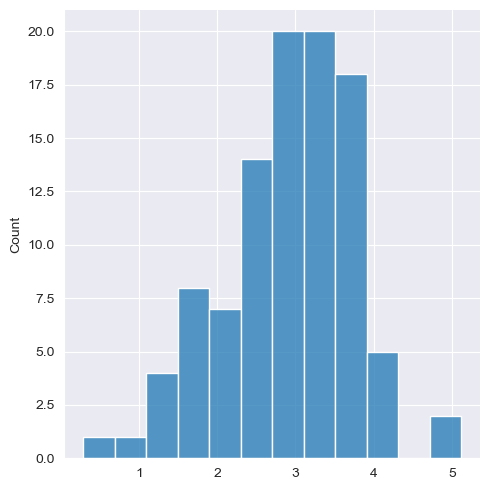

In [3]:
# パラメータの設定
n_sample = 100
true_mean = 3.0
true_ed = 1.0

# 乱数生成器
rng = np.random.default_rng(seed=1)

# 人工データの生成
data = rng.normal(true_mean, true_ed, n_sample)

sns.displot(data, kde=False)

In [4]:
# メトロポリス・ヘイスティング法
n_iter = 6000
step_size= .3
z_init = 0.0

# 現在のサンプルの値
z_current = z_init
# サンプルを保存するリスト
posterior = []
# 提案分布からのサンプルが受容された回数
n_accepted = 0


def unnormalized_log_posterior(z):
    """対数事後分布の計算"""
    likelihood = stats.norm(z, true_ed).logpdf(data).sum()
    prior = stats.norm(0, 10).logpdf(z)
    return prior + likelihood

In [5]:
for i in tqdm(range(n_iter)):
    # 撹乱項 ε は平均 0 の一様分布に従うとする
    z_proposal = z_current + step_size * rng.uniform(-1, 1)

    logp_current = unnormalized_log_posterior(z_current)
    logp_proposal = unnormalized_log_posterior(z_proposal)

    # [0, 1] の一様分布からのサンプル
    r = rng.random()

    # MH基準に従い提案された値を受容するかどうか判定
    # logp_proposal > logp_current なら必ず受容
    # logp_proposal < logp_current の場合は, np.exp(logp_proposal - logp_current) > r の確率で受容
    if np.exp(logp_proposal - logp_current) > r:
        n_accepted += 1
        z_current = z_proposal
    posterior.append(z_current)

print("acceptance ratio: {:.3f}".format(n_accepted / n_iter))

100%|██████████| 6000/6000 [00:11<00:00, 543.57it/s]

acceptance ratio: 0.491


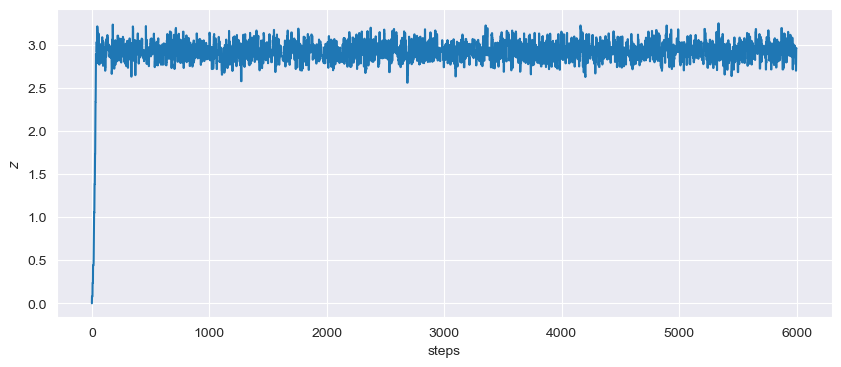

In [6]:
# trace-plot drawing.
plt.figure(figsize=(10, 4))
plt.plot(posterior, lw=1.5)
plt.xlabel("steps")
plt.ylabel("$z$")
plt.show()

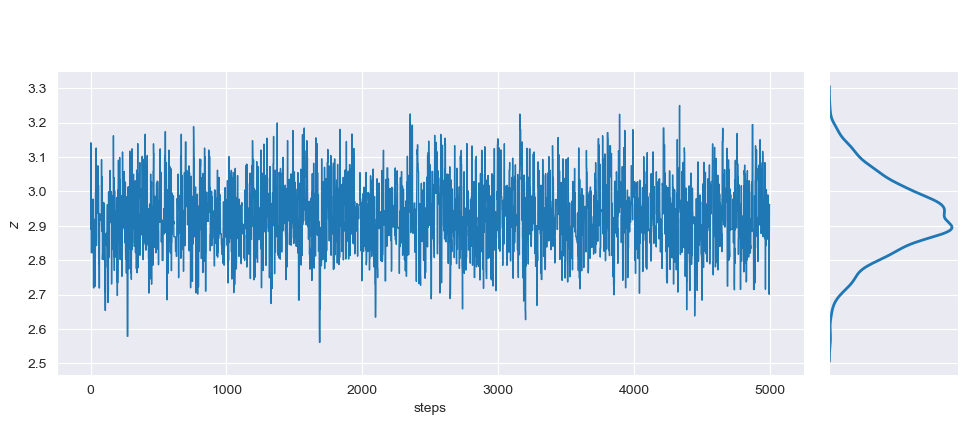

In [7]:
n_burnin = 1000
x, y = np.arange(n_iter - n_burnin), posterior[n_burnin:]

# seaborn で複数のプロットを組み合わせるためのクラス
g = sns.JointGrid()
# メインのプロット
sns.lineplot(x=x, y=y, linewidth=1, ax=g.ax_joint)
# y軸に付随するプロット
sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y)
g.ax_joint.set_xlabel("steps")
g.ax_joint.set_ylabel("$z$")
g.ax_marg_x.set_axis_off()
g.fig.set_figwidth(10)
g.fig.set_figheight(4)

100%|██████████| 4000/4000 [00:07<00:00, 553.30it/s]


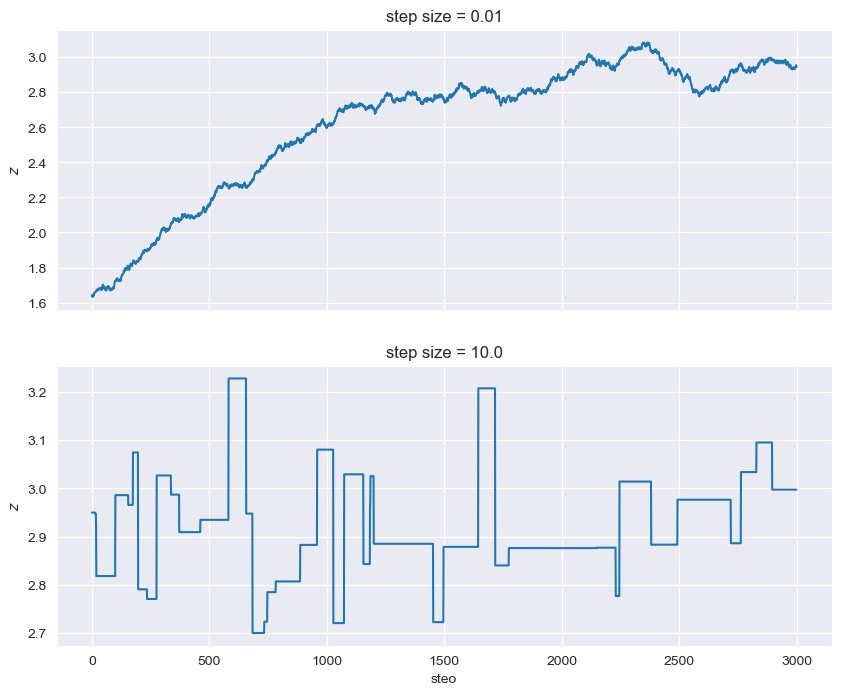

In [8]:
def randomwalk_MH(x_init, step_size=0.30, n_iter=6000, n_burnin=1000, seed=1):
    """ランダムウォークMH."""
    x_current = x_init
    posterior = []

    rng = np.random.default_rng(seed=seed)

    for i in tqdm(range(n_iter)):
        x_proposal = x_current + step_size * rng.uniform(-1, 1)

        r = rng.random()
        logp_current = unnormalized_log_posterior(x_current)
        logp_prop = unnormalized_log_posterior(x_proposal)
        if np.exp(logp_prop - logp_current) > r:
            x_current = x_proposal
        posterior.append(x_current)

    return posterior[n_burnin:]


# ステップサイズが小さ過ぎる場合
posterior_small_step = randomwalk_MH(0, 0.01, 4000, 1000)
# ステップサイズが大き過ぎる場合
posterior_large_step = randomwalk_MH(0, 10, 4000, 1000)

# トレースプロット
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
ax = axes[0]
ax.plot(posterior_small_step)
ax.set_title("step size = 0.01")
ax.set_ylabel("$z$")

ax = axes[1]
ax.plot(posterior_large_step)
ax.set_title("step size = 10.0")
ax.set_xlabel("steo")
ax.set_ylabel("$z$")
plt.show()

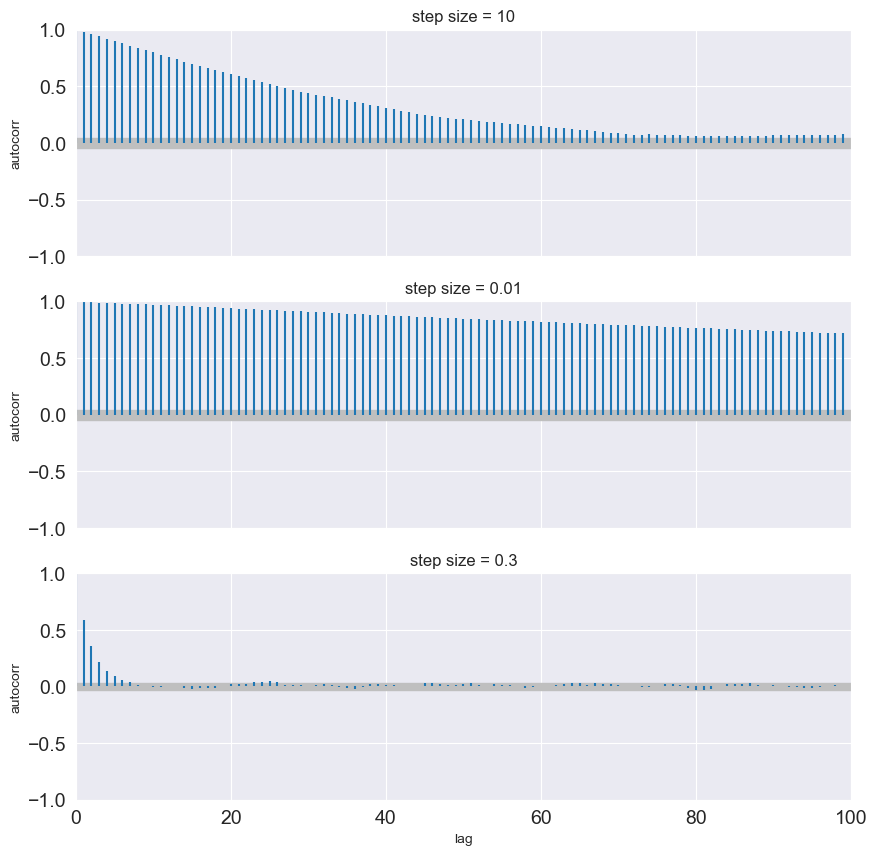

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

ax = axes[0]
az.plot_autocorr(np.array(posterior_large_step[n_burnin:]), ax=ax)
ax.set_title("step size = 10")
ax.set_ylabel("autocorr")

ax = axes[1]
az.plot_autocorr(np.array(posterior_small_step[n_burnin:]), ax=ax)
ax.set_title("step size = 0.01")
ax.set_ylabel("autocorr")

ax = axes[2]
az.plot_autocorr(np.array(posterior[n_burnin:]), ax=ax)
ax.set_title("step size = 0.3")
ax.set_xlabel("lag")
ax.set_ylabel("autocorr")
plt.show()

In [10]:
# 3つのチェーンによるサンプリング
x_inits = rng.uniform(-1, 1, 3)
posteriors = [randomwalk_MH(x_init) for x_init in x_inits]
posteriors = np.array(posteriors).transpose()

100%|██████████| 6000/6000 [00:10<00:00, 569.25it/s]


Text(0.5, 0, '$z$')

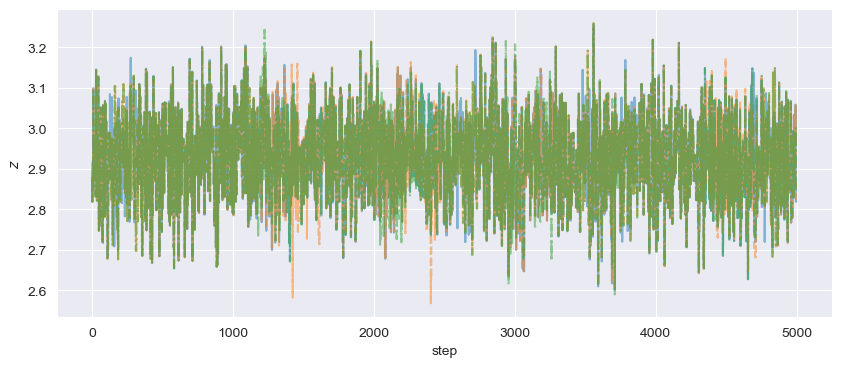

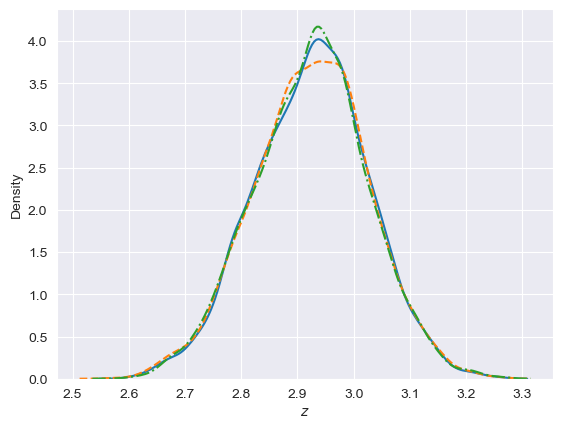

In [12]:
# トレースプロット
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(posteriors[:, 0], lw=1.5, alpha=0.5)
ax.plot(posteriors[:, 1], lw=1.5, alpha=0.5, ls="--")
ax.plot(posteriors[:, 2], lw=1.5, alpha=0.5, ls="-.")
ax.set_xlabel("step")
ax.set_ylabel("$z$")

# 事後分布の可視化
fig, ax = plt.subplots()
sns.kdeplot(posteriors[:, 0])
sns.kdeplot(posteriors[:, 1], ls="--")
sns.kdeplot(posteriors[:, 2], ls="-.")
ax.set_xlabel("$z$")

In [14]:
rhat = az.rhat(posteriors.transpose())
print(f"Rhat: {rhat:.3f}")

Rhat: 1.003


### 1.4.12 変分推論法の具体例

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

tf.random.set_seed(1)

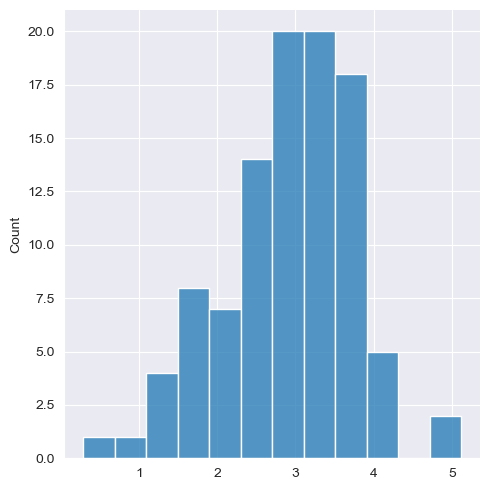

In [11]:
# パラメータの設定
n_sample = 100
true_mean = 3.0
true_sd = 1.0

# 乱数生成器
rng = np.random.default_rng(seed=1)

# 人工データの生成
data = rng.normal(true_mean, true_sd, n_sample)

sns.displot(data, kde=False)

Text(0, 0.5, 'negative ELBO')

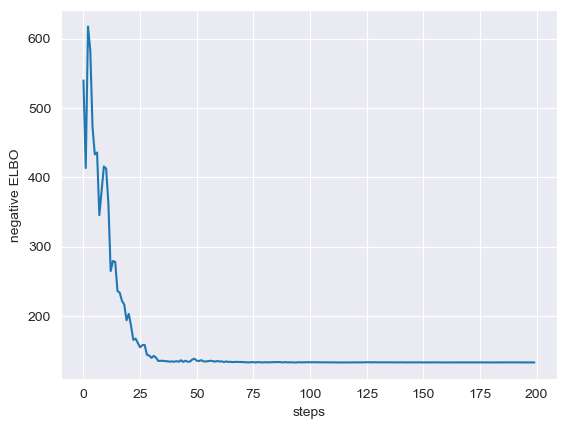

In [12]:
Root = tfd.JointDistributionCoroutine.Root
def model():
    mu = yield Root(tfd.Normal(loc=0, scale=10))  # 事前分布
    y = yield tfd.Sample(
        tfd.Normal(loc=mu, scale=true_sd),
        sample_shape=n_sample
    )

joint = tfd.JointDistributionCoroutine(model)

def unnormalized_log_posterior(mu):
    return joint.log_prob(mu, data)

q_mu_loc = tf.Variable(0., name="q_mu_loc")
q_mu_scale = tfp.util.TransformedVariable(1., tfb.Softplus(), name="q_mu_scale")
q_mu = tfd.Normal(loc=q_mu_loc, scale=q_mu_scale, name="q_mu")

losses = tfp.vi.fit_surrogate_posterior(
    unnormalized_log_posterior,
    surrogate_posterior=q_mu,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=200,
    sample_size=20,
    seed=1
)

plt.plot(losses)
plt.xlabel("steps")
plt.ylabel("negative ELBO")